Loaded datasets with 3 time steps and 6 forecast steps.
총 3개의 초기장에 대한 6단계 시각화를 시작합니다.


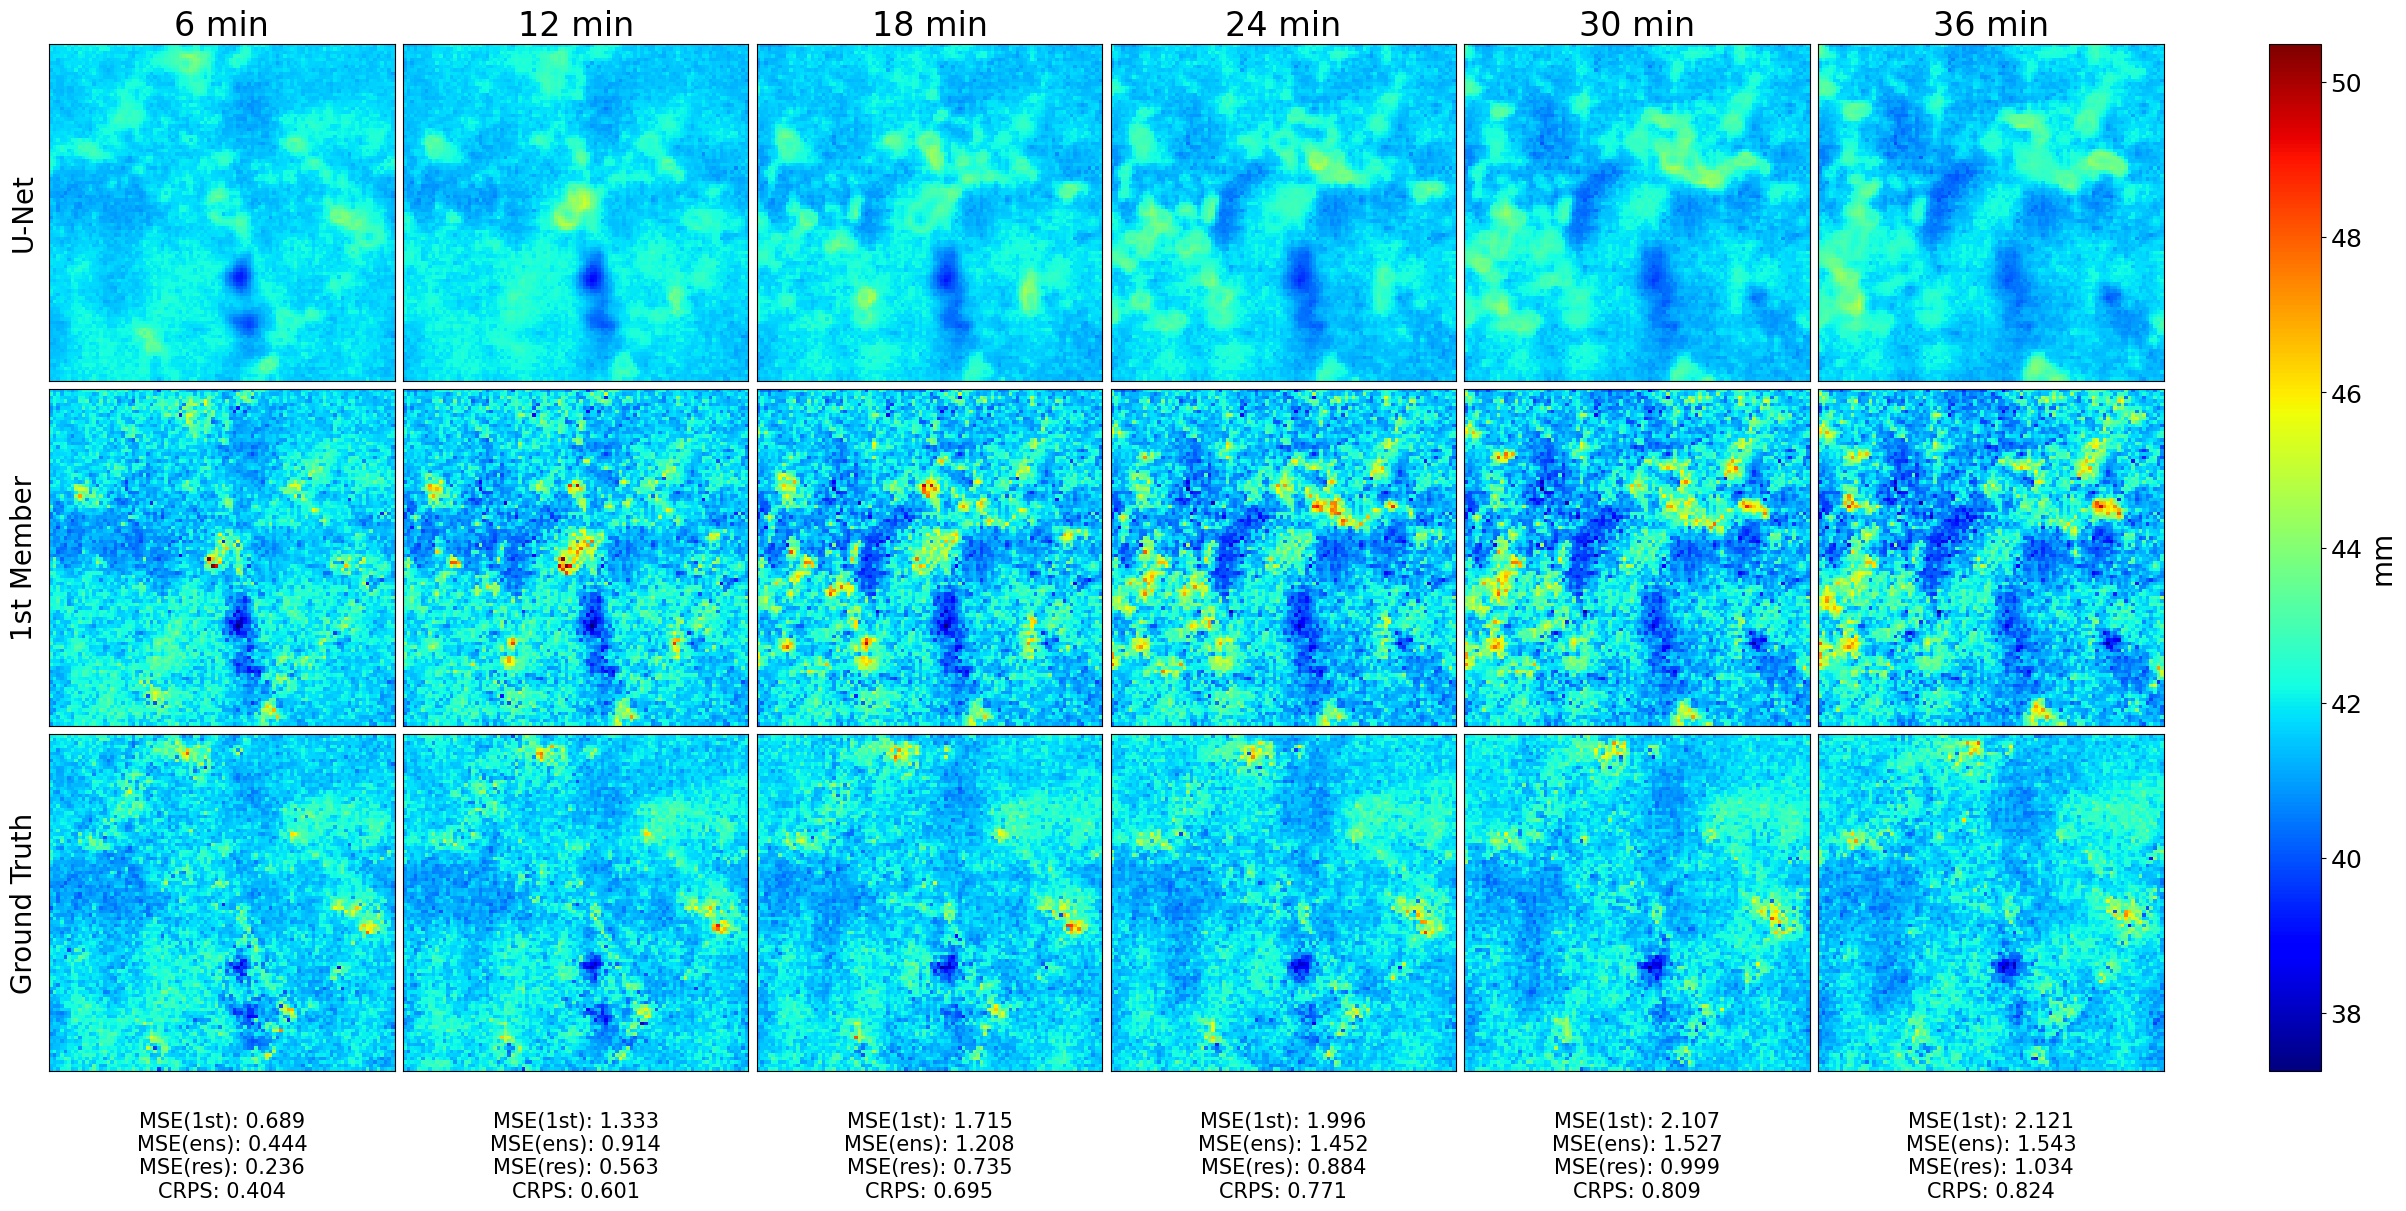

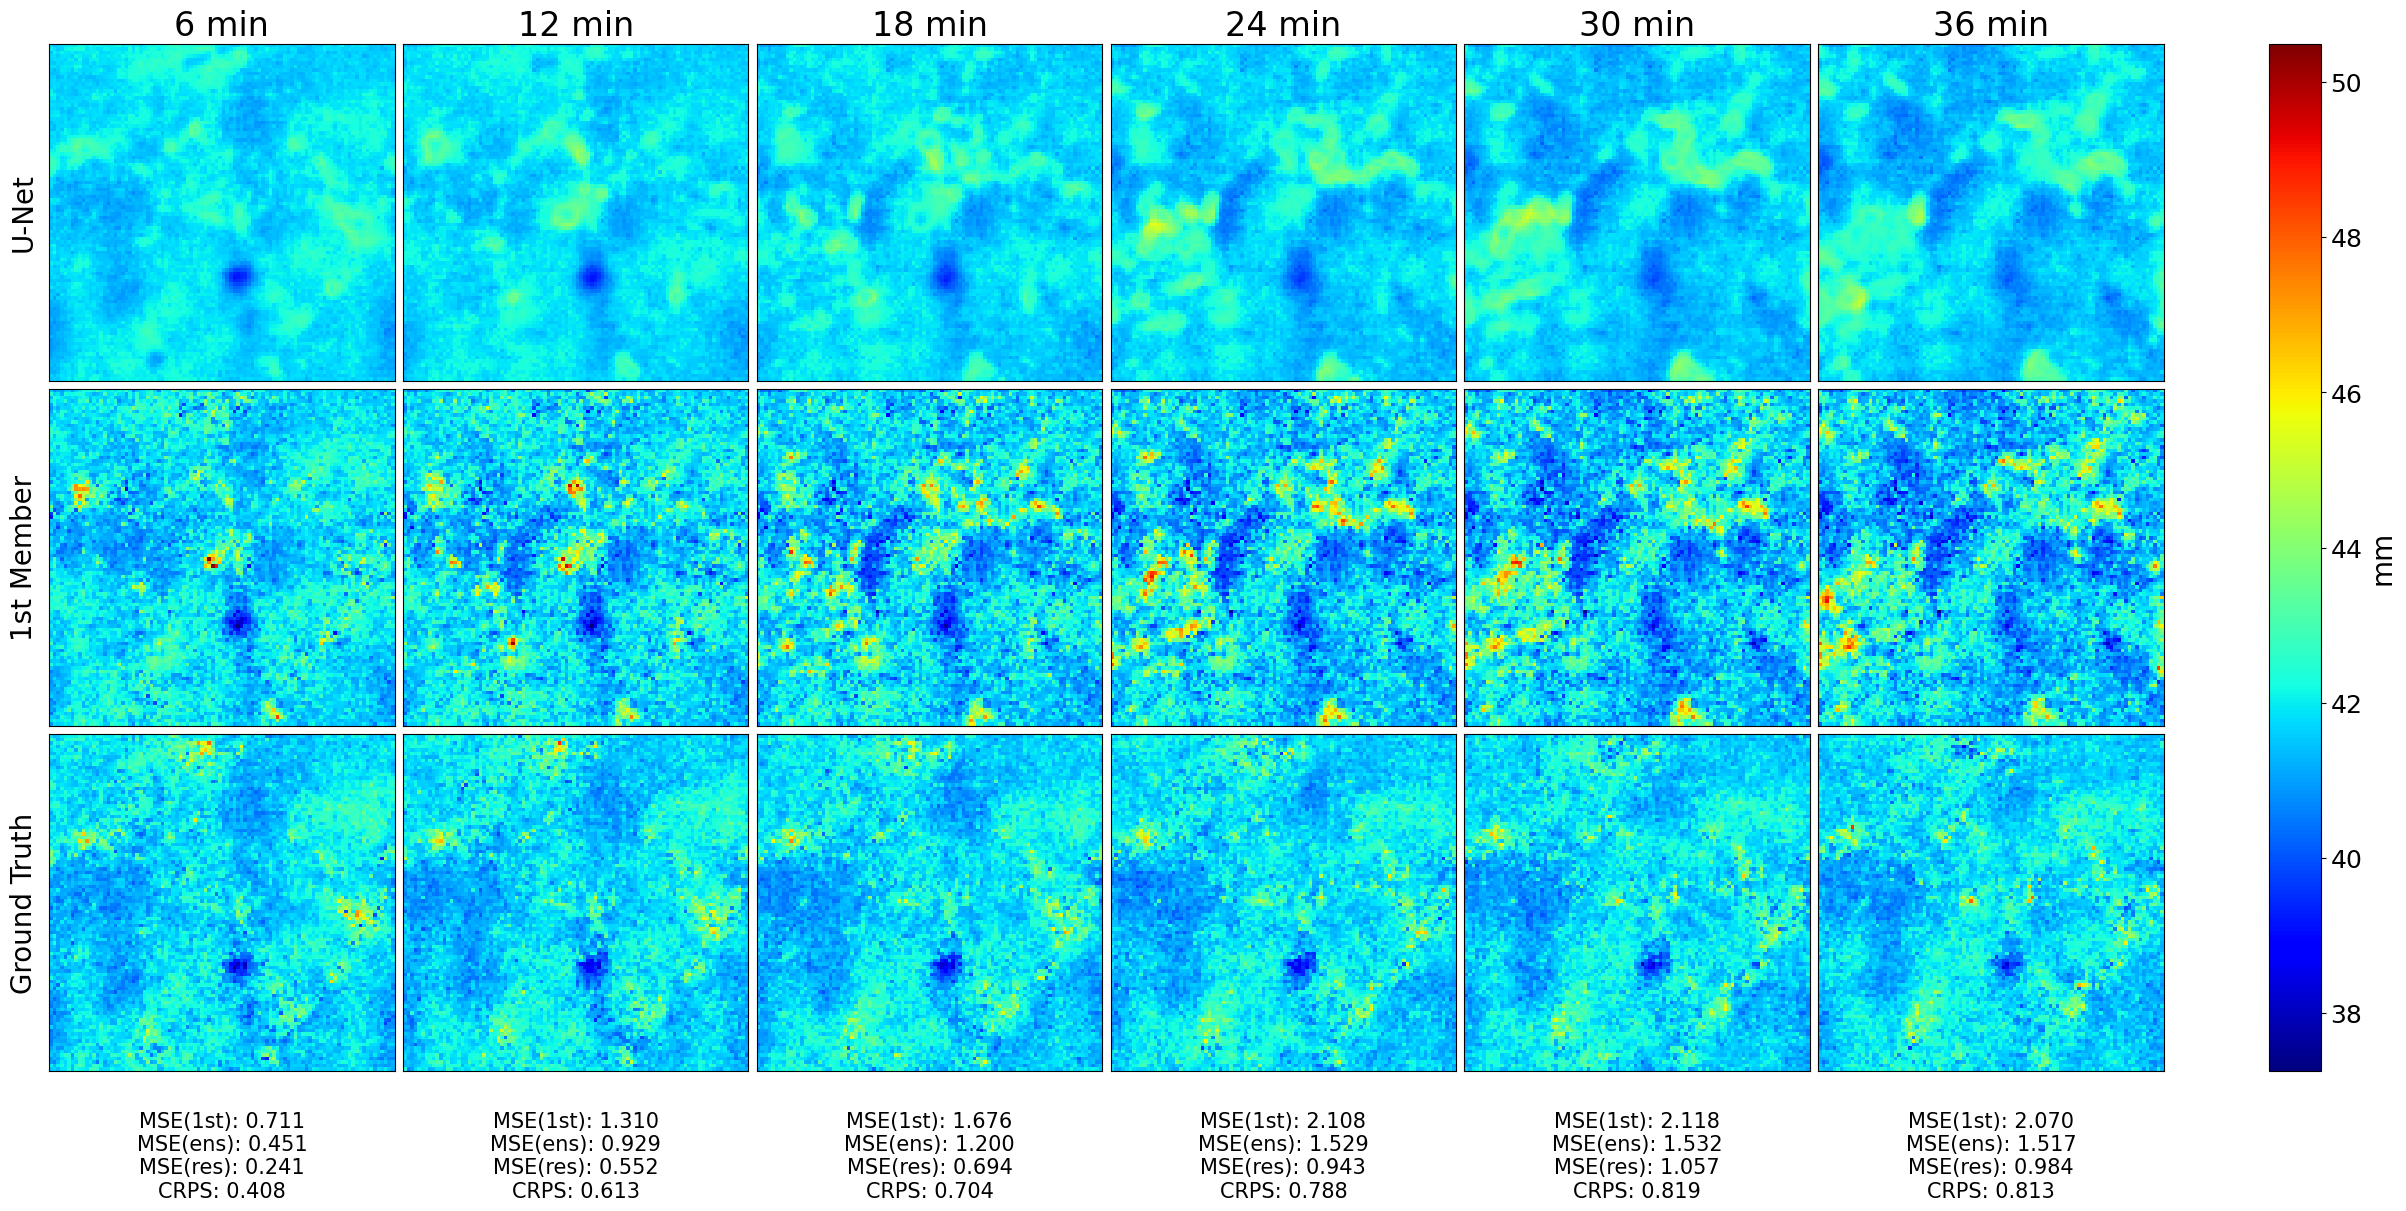

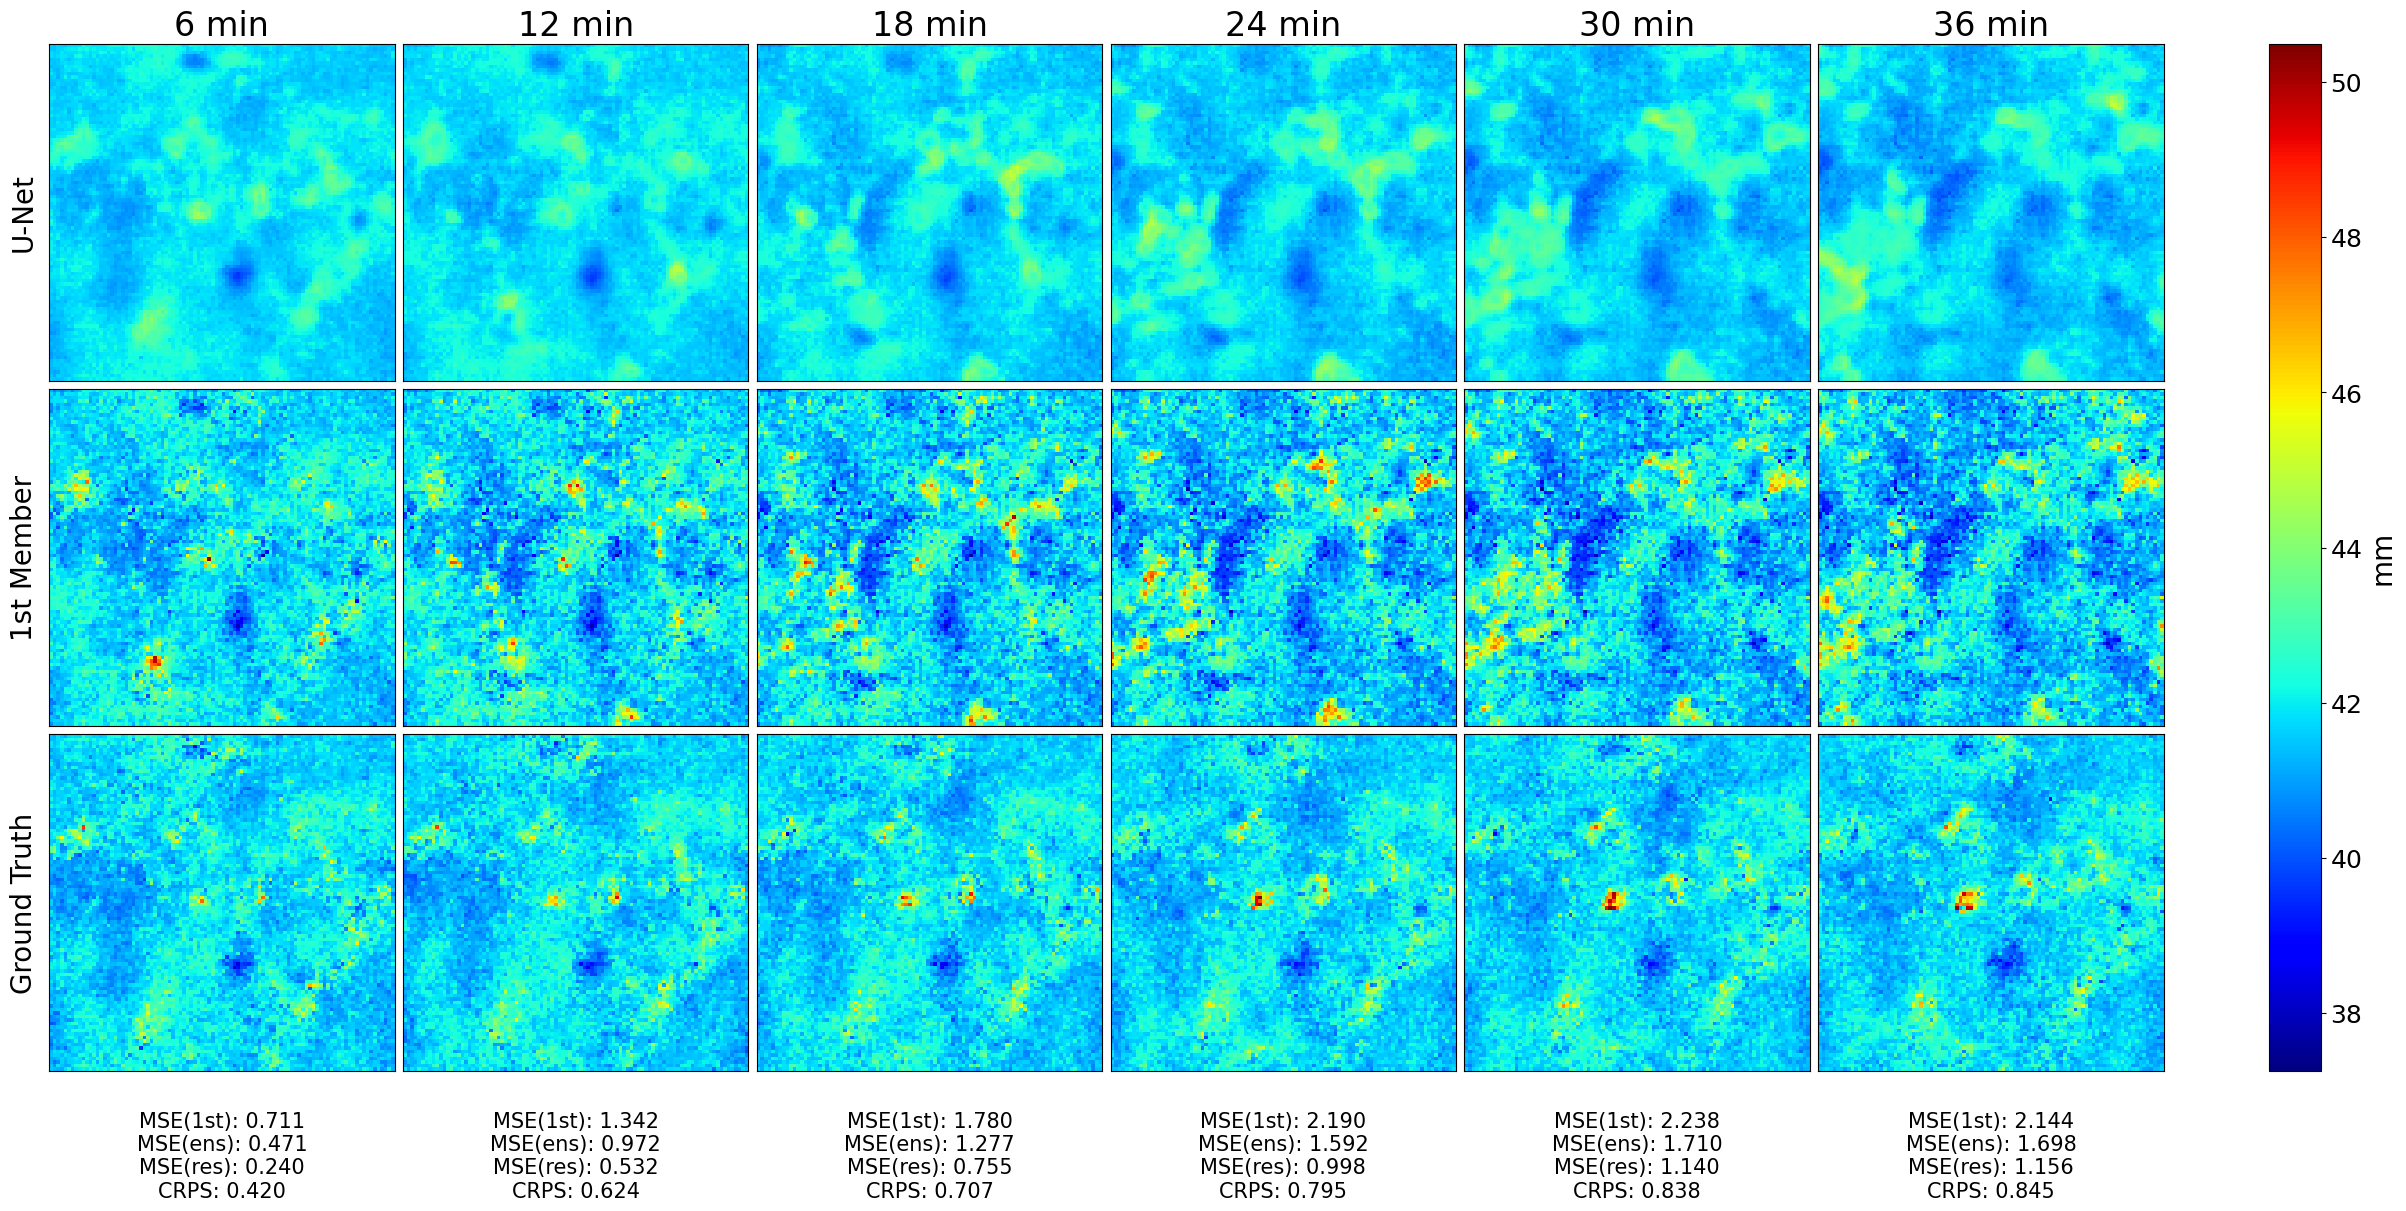

Saved: visualization_results/PW_t000.png
Saved: visualization_results/PW_t001.png
Saved: visualization_results/PW_t002.png


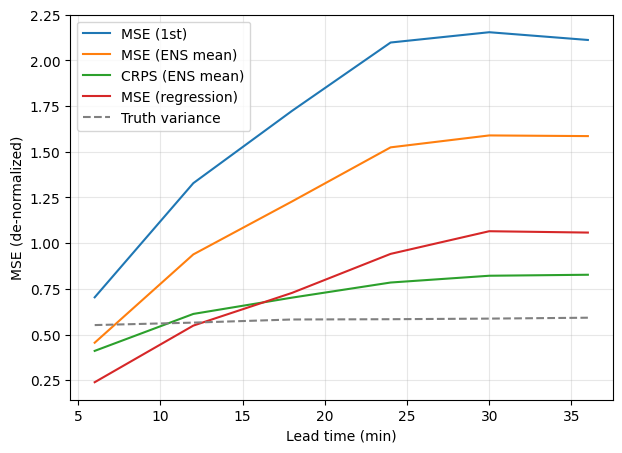

Aggregated metric plots are saved in 'visualization_results'.


In [1]:
import os
from typing import Dict, List, Optional, Tuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import properscoring as ps


class AutoRegForecastVisualizer:
    """
    Autoregressive forecast visualizer & scorer.

    - Loads NetCDF groups: coords(root), input, truth, prediction, regression
    - Handles optional de-normalization with mean/std (npy)
    - Crops borders (e.g., halo) consistently across all fields
    - Computes MSE (1st member / ensemble-mean / regression) & CRPS (ensembles)
    - Plots a 3 x num_steps panel per selected time (regression, 1st member, truth)
    - Saves figures into an output directory
    """

    def __init__(
        self,
        nc_path: str,
        var: str,
        output_dir: str = "visualization_results",
        mean_std_npy: Optional[str] = None,
        delta_min: int = 30, #minnutes
        crop: int = 16,
        decode_times: bool = False,
        first_member_index: int = 0,
        cmap: str = "jet",
        unit_label: str = "mm",
    ) -> None:
        self.nc_path = nc_path
        self.var = var
        self.output_dir = output_dir
        self.mean_std_npy = mean_std_npy
        self.delta_min = delta_min
        self.crop = crop
        self.decode_times = decode_times
        self.first_member_index = first_member_index
        self.cmap = cmap
        self.unit_label = unit_label

        os.makedirs(self.output_dir, exist_ok=True)

        # Will be set in load()
        self.ds_coords: xr.Dataset
        self.ds_input: xr.Dataset
        self.ds_truth: xr.Dataset
        self.ds_pred: xr.Dataset
        self.ds_res: xr.Dataset
        self.lat: np.ndarray
        self.lon: np.ndarray
        self.mean: float = 0.0
        self.std: float = 1.0
        self.num_times: int = 0
        self.num_steps: int = 0

    # ------------------------------
    # Data I/O & preparation
    # ------------------------------
    def load(self) -> None:
        """Open datasets and prepare coordinates, shapes, and normalization."""
        # Open groups
        self.ds_coords = xr.open_dataset(self.nc_path, decode_times=self.decode_times)
        self.ds_input = xr.open_dataset(self.nc_path, group="input", decode_times=self.decode_times)
        self.ds_truth = xr.open_dataset(self.nc_path, group="truth", decode_times=self.decode_times)
        self.ds_pred = xr.open_dataset(self.nc_path, group="prediction", decode_times=self.decode_times)
        self.ds_res = xr.open_dataset(self.nc_path, group="regression", decode_times=self.decode_times)

        # Crop lat/lon once and reuse
        if self.crop and self.crop > 0:
            self.lat = self.ds_coords["lat"].values[self.crop : -self.crop, self.crop : -self.crop]
            self.lon = self.ds_coords["lon"].values[self.crop : -self.crop, self.crop : -self.crop]
        else:
            self.lat = self.ds_coords["lat"].values
            self.lon = self.ds_coords["lon"].values

        self.num_times = int(self.ds_pred.sizes["time"]) if "time" in self.ds_pred.sizes else 1
        self.num_steps = int(self.ds_pred.sizes["step"]) if "step" in self.ds_pred.sizes else 1
        print(f"Loaded datasets with {self.num_times} time steps and {self.num_steps} forecast steps.")

        # Normalization (optional)
        if self.mean_std_npy and os.path.exists(self.mean_std_npy):
            arr = np.load(self.mean_std_npy)
            # Assumes shape [2, C] or [2, ...]; take the channel-0 stats if 1 channel
            self.mean = float(arr[0][0])
            self.std = float(arr[1][0]) if arr[1][0] != 0 else 1.0
        else:
            self.mean, self.std = 0.0, 1.0

    # ------------------------------
    # Utilities
    # ------------------------------
    def _crop(self, da: xr.DataArray) -> xr.DataArray:
        if self.crop and self.crop > 0:
            return da[..., self.crop : -self.crop, self.crop : -self.crop]
        return da

    def _denorm(self, arr: np.ndarray) -> np.ndarray:
        return arr * self.std + self.mean

    def global_value_range(self) -> Tuple[float, float]:
        """Compute global min/max from TRUTH (then de-normalize) for consistent colormap."""
        vmin = float(self.ds_truth[self.var].min())
        vmax = float(self.ds_truth[self.var].max())
        vmin = self._denorm(vmin)
        vmax = self._denorm(vmax)
        return vmin, vmax

    # ------------------------------
    # Scoring
    # ------------------------------
    @staticmethod
    def _mse(truth: np.ndarray, pred: np.ndarray) -> float:
        return float(((truth - pred) ** 2).mean())

    def scores_for_time(self, t: int) -> Dict[str, List[float]]:
        """
        Compute per-step scores at a given time index t.
        Returns dict with lists keyed by metric/model.
        Keys:
          - mse_1st, mse_ens_mean, mse_res, crps
        """
        assert 0 <= t < self.num_times
        truth_all = self._crop(self.ds_truth[self.var].isel(time=t))  # (step, y, x)
        pred_ens_all = self._crop(self.ds_pred[self.var].isel(time=t))  # (ensemble, step, y, x)
        res_all = self._crop(self.ds_res[self.var].isel(time=t))  # (step, y, x)

        # Convert to numpy
        truth_np = truth_all.values  # (step, y, x)
        pred_ens_np = pred_ens_all.values  # (ensemble, step, y, x)
        res_np = res_all.values  # (step, y, x)

        # De-normalize for plotting & for MSE in physical units
        truth_dn = self._denorm(truth_np)
        res_dn = self._denorm(res_np)
        pred_1st_dn = self._denorm(pred_ens_np[self.first_member_index])  # (step, y, x)
        pred_mean_dn = self._denorm(pred_ens_np.mean(axis=0))

        mse_1st = []
        mse_ens_mean = []
        mse_res = []
        crps_list = []


        for s in range(self.num_steps):
            # MSEs in de-normalized space
            mse_1st.append(self._mse(truth_dn[s], pred_1st_dn[s]))
            mse_ens_mean.append(self._mse(truth_dn[s], pred_mean_dn[s]))
            mse_res.append(self._mse(truth_dn[s], res_dn[s]))

            # CRPS over ensembles (axis=0 is ensemble)
            # Use raw (or de-normalized) consistently; choose de-normalized here for interpretability
            crps = ps.crps_ensemble(truth_dn[s], self._denorm(pred_ens_np[:, s, ...]), axis=0).mean()
            crps_list.append(float(crps))

        return {
            "mse_1st": mse_1st,
            "mse_ens_mean": mse_ens_mean,
            "mse_res": mse_res,
            "crps": crps_list,
        }
    
    def scores_by_step(self):
        truth_all = self._crop(self.ds_truth[self.var])  # (time, step, y, x)
        pred_ens_all = self._crop(self.ds_pred[self.var])  # (ens, time, step, y, x)
        res_all = self._crop(self.ds_res[self.var])  # (time, step, y, x)

        truth_dn = self._denorm(truth_all.values)
        res_dn = self._denorm(res_all.values)
        pred_1st_dn = self._denorm(pred_ens_all.values[self.first_member_index])
        pred_mean_dn = self._denorm(pred_ens_all.values.mean(axis=0))

        mse_1st = ((truth_dn - pred_1st_dn)**2).mean(axis=(0,2,3))
        mse_ens_mean = ((truth_dn - pred_mean_dn)**2).mean(axis=(0,2,3))
        mse_res = ((truth_dn - res_dn)**2).mean(axis=(0,2,3))
        crps = ps.crps_ensemble(truth_dn, self._denorm(pred_ens_all.values), axis=0).mean(axis=(0,2,3))
        truth_var = truth_dn.var(axis=(0,2,3))

        return {
            "mse_1st": mse_1st,
            "mse_ens_mean": mse_ens_mean,
            "mse_res": mse_res,
            "crps": crps,
            "truth_var": truth_var
        }


    # ------------------------------
    # Plotting
    # ------------------------------
    def plot_time_panel(self, t: int, outfile: Optional[str] = None) -> str:
        """
        Plot a 3 x num_steps panel for time index t:
          Row0: Regression (UNet)
          Row1: Prediction (1st member)
          Row2: Truth
        Writes PNG and returns the file path.
        """
        assert 0 <= t < self.num_times
        vmin, vmax = self.global_value_range()

        truth_all = self._crop(self.ds_truth[self.var].isel(time=t))  # (step, y, x)
        pred_ens_all = self._crop(self.ds_pred[self.var].isel(time=t))  # (ensemble, step, y, x)
        res_all = self._crop(self.ds_res[self.var].isel(time=t))  # (step, y, x)

        truth_dn = self._denorm(truth_all.values)
        res_dn = self._denorm(res_all.values)
        pred_1st_dn = self._denorm(pred_ens_all.values[self.first_member_index])

        lat = self.lat
        lon = self.lon

        fig, axes = plt.subplots(nrows=3, ncols=self.num_steps, figsize=(4 * self.num_steps, 12), constrained_layout=True)

        scores = self.scores_for_time(t)

        for s in range(self.num_steps):
            # Row 0: Regression
            ax0 = axes[0, s]
            im = ax0.pcolormesh(lon, lat, res_dn[s], vmin=vmin, vmax=vmax, cmap=self.cmap, shading="auto")
            ax0.set_xticks([])
            ax0.set_yticks([])
            ax0.set_title(f"{(s + 1) * self.delta_min} min", fontsize=24)

            # Row 1: Prediction (1st member)
            ax1 = axes[1, s]
            ax1.pcolormesh(lon, lat, pred_1st_dn[s], vmin=vmin, vmax=vmax, cmap=self.cmap, shading="auto")
            ax1.set_xticks([])
            ax1.set_yticks([])

            # Row 2: Truth
            ax2 = axes[2, s]
            ax2.pcolormesh(lon, lat, truth_dn[s], vmin=vmin, vmax=vmax, cmap=self.cmap, shading="auto")
            ax2.set_xticks([])
            ax2.set_yticks([])

            # Score text under row 2
            score_text = f"MSE(1st): {scores['mse_1st'][s]:.3f}\nMSE(ens): {scores['mse_ens_mean'][s]:.3f}\nMSE(res): {scores['mse_res'][s]:.3f}\nCRPS: {scores['crps'][s]:.3f}"
            ax2.text(0.5, -0.12, score_text, ha="center", va="top", fontsize=15, transform=ax2.transAxes)

        axes[0, 0].set_ylabel("U-Net", fontsize=20, labelpad=8)
        axes[1, 0].set_ylabel("1st Member", fontsize=20, labelpad=8)
        axes[2, 0].set_ylabel("Ground Truth", fontsize=20, labelpad=8)

        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label=f"{self.var} units")
        cbar.ax.tick_params(labelsize=18)
        cbar.set_label(self.unit_label, fontsize=20)

        if outfile is None:
            outfile = os.path.join(self.output_dir, f"{self.var}_t{t:03d}.png")
        fig.savefig(outfile, dpi=300)
        # plt.close(fig)
        plt.show()
        return outfile

    def plot_first_n_times(self, n: int = 3) -> List[str]:
        n = min(n, self.num_times)
        paths = []
        for t in range(n):
            paths.append(self.plot_time_panel(t))
        return paths

    # ------------------------------
    # Aggregated metrics across time
    # ------------------------------
    def plot_step_metric_curves(self, agg: Dict[str, np.ndarray], outfile: Optional[str] = None) -> str:
        """
        Plot line curves over steps for averaged metrics.
        """
        # TODO: Chagne gap_min code flexible
        steps = np.arange(1, self.num_steps + 1) * self.delta_min  # minutes #!Hard-coding 

        # MSE curves
        plt.figure(figsize=(7, 5))
        plt.plot(steps, agg["mse_1st"], label="MSE (1st)")
        plt.plot(steps, agg["mse_ens_mean"], label="MSE (ENS mean)")
        plt.plot(steps, agg["crps"], label="CRPS (ENS mean)")
        plt.plot(steps, agg["mse_res"], label="MSE (regression)")
        plt.plot(steps, agg["truth_var"], label="Truth variance", linestyle='--', color='gray')
        plt.xlabel("Lead time (min)")
        plt.ylabel("MSE (de-normalized)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        if outfile is None:
            outfile = os.path.join(self.output_dir, f"{self.var}_mse_by_step.png")
        plt.savefig(outfile, dpi=300)
        # plt.close()
        plt.show()

        return outfile


# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    nc_file_path = "/scratch/x3108a06/generate_output/corrdiff_autoregressive_output.nc"
    variable_to_plot = "PW"
    mean_std_path = "/scratch/x3108a06/input_data/2D/PW_1m/mean_std_100d_1m.npy"

    vis = AutoRegForecastVisualizer(
        nc_path=nc_file_path,
        var=variable_to_plot,
        mean_std_npy=mean_std_path,
        crop=16,
        first_member_index=0,  # or 1 if your dataset's first member is indexed at 1
        unit_label="mm",
        delta_min=6
    )
    vis.load()

    print(f"총 {vis.num_times}개의 초기장에 대한 {vis.num_steps}단계 시각화를 시작합니다.")

    # Panels for first N forecast time
    paths = vis.plot_first_n_times(n=5)
    for p in paths:
        print(f"Saved: {p}")

    # Aggregated curves across all times
    agg = vis.scores_by_step()
    vis.plot_step_metric_curves(agg)
    print(f"Aggregated metric plots are saved in '{vis.output_dir}'.")

